![alt text](http://datascience.uci.edu/wp-content/uploads/sites/2/2014/09/data_science_logo_with_image1.png 'UCI_data_science')

### Goals of this Lesson
- Extend the regression framework to support classification
    - Logistic Regression
    - Training with Gradient Descent
    - Training with Newton's Method
    
- Implement... 
    - The Logistic function
    - A function to compute the Hessian matrix
    - An instantiation of SciKit-Learn's Logistic regression class

### References 
- Chapter 4 of [*Elements of Statistical Learning* by Hastie, Tibshirani, Friedman](http://web.stanford.edu/~hastie/local.ftp/Springer/OLD/ESLII_print4.pdf) 
- [A Few Useful Things to Know about Machine Learning](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf)
- [SciKit-Learn's Logistic Regression Documentation](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)


## 0.  Python Preliminaries
As usual, first we need to import Numpy, Pandas, MatPlotLib...

In [2]:
from IPython.display import Image
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
%matplotlib inline

I've created two functions that we'll use later to visualize which datapoints are being assigned to which classes.  They are a bit messy and not essential to the material so don't worry about understanding them.  I'll be happy to explain them to anyone interested during a break or after the session.  

In [3]:
from matplotlib.colors import ListedColormap

# A somewhat complicated function to make pretty plots
def plot_classification_data(data1, data2, beta, logistic_flag=False):
    plt.figure()
    grid_size = .2
    features = np.vstack((data1, data2))
    # generate a grid over the plot
    x_min, x_max = features[:, 0].min() - .5, features[:, 0].max() + .5
    y_min, y_max = features[:, 1].min() - .5, features[:, 1].max() + .5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_size), np.arange(y_min, y_max, grid_size))
    # color the grid based on the predictions 
    if logistic_flag:
        Z = logistic(np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], beta))
        colorbar_label=r"Value of f($X \beta)$"
    else:
        Z = np.dot(np.c_[xx.ravel(), yy.ravel(), np.ones(xx.ravel().shape[0])], beta)
        colorbar_label=r"Value of $X \beta$"
    Z = Z.reshape(xx.shape)
    background_img = plt.pcolormesh(xx, yy, Z, cmap=plt.cm.coolwarm)
    
    # Also plot the training points
    plt.scatter(class1_features[:, 0], class1_features[:, 1], c='b', edgecolors='k', s=70)
    plt.scatter(class2_features[:, 0], class2_features[:, 1], c='r', edgecolors='k', s=70)
    plt.title('Data with Class Prediction Intensities')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    color_bar = plt.colorbar(background_img, orientation='horizontal')
    color_bar.set_label(colorbar_label)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.show()

# Another messy looking function to make pretty plots of basketball courts
def visualize_court(log_reg_model, court_image = './data/nba_experiment/nba_court.jpg'):
    two_class_cmap = ListedColormap(['#FFAAAA', '#AAFFAA']) # light red for miss, light green for make
    x_min, x_max = 0, 50 #width (feet) of NBA court
    y_min, y_max = 0, 47 #length (feet) of NBA half-court
    grid_step_size = 0.2
    grid_x, grid_y = np.meshgrid(np.arange(x_min, x_max, grid_step_size), np.arange(y_min, y_max, grid_step_size))
    grid_predictions = log_reg_model.predict(np.c_[grid_x.ravel(), grid_y.ravel()])
    grid_predictions = grid_predictions.reshape(grid_x.shape)
    fig, ax = plt.subplots()
    court_image = plt.imread(court_image)
    ax.imshow(court_image, interpolation='bilinear', origin='lower',extent=[x_min,x_max,y_min,y_max])
    ax.imshow(grid_predictions, cmap=two_class_cmap, interpolation = 'nearest',
              alpha = 0.60, origin='lower',extent=[x_min,x_max,y_min,y_max])
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title( "Make / Miss Prediction Boundaries" )
    plt.show()

## 1.  Classes as Targets

Now that we've seen how to train and evaluate a linear model for real-valued responses, next we turn to classification.  At first glance, jumping from regression to classification seems trivial.  Say there are two classes, the first denoted by 0 and the second by 1.  We could just set each $y_{i}$ to 0 or 1 according to its class membership and fit a linear model just as before.

_** Here's an example doing just that on some artificial data... **_

Classification Error on Training Set: 9.75%


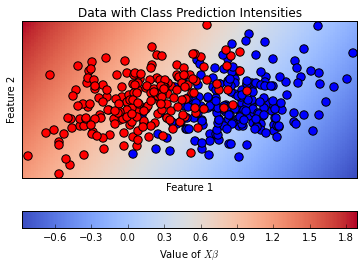

In [6]:
### function for shuffling the data and labels
def shuffle_in_unison(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)
    
### calculate classification errors
# return a percentage: (number misclassified)/(total number of datapoints)
def calc_classification_error(predictions, class_labels):
    n = predictions.size
    num_of_errors = 0.
    for idx in xrange(n):
        if (predictions[idx] >= 0.5 and class_labels[idx]==0) or (predictions[idx] < 0.5 and class_labels[idx]==1):
            num_of_errors += 1
    return num_of_errors/n

# set the random number generator for reproducability
np.random.seed(182)

#### create artificial data
N = 400
D = 2
# Sample the features from a Multivariate Normal Dist.
mean1 = [13,5]
mean2 = [5,5]
covariance = [[13,5],[5,13]]
class1_features = np.random.multivariate_normal(mean1,covariance,N/2)
class2_features = np.random.multivariate_normal(mean2,covariance,N/2)
features = np.vstack((class1_features, class2_features))
# add column of ones for bias term
features = np.hstack((features,np.ones((N,1))))
# Set the class labels
class1_labels = [0]*(N/2)
class2_labels = [1]*(N/2)
class_labels = class1_labels+class2_labels
# shuffle the data
shuffle_in_unison(features, class_labels)
class_labels = np.array(class_labels)[np.newaxis].T

### fit the linear model --- OLS Solution
beta = np.dot(np.linalg.inv(np.dot(features.T, features)),np.dot(features.T,class_labels))

### compute error on training data
predictions = np.dot(features, beta)
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

### generate a plot
plot_classification_data(class1_features, class2_features, beta)

That worked okay.  9.75% error is respectable.  Yet, let's think a bit harder about what's going on...
* It seems a bit arbitary to set the class labels to 0 vs. 1.  Why couldn't we have set them to -1 vs. +1?  Or 500 vs. 230?  The responses don't have the same intrinsic meaning they did before.  Now the labels represent exclusive class membership whereas before they represented physical quantities (baseball player's salary, for example).      
* During training, we're optimizing squared error, but the metric we truly care about is classification percentage.  Squared distance seems inappropriate especially when it's not even clear to what value the responses should be set.

Here's an idea: since we care primarily about classification error, let's make that our loss function...

\begin{eqnarray*}
\mathcal{L}_{\mathrm{class}} = \begin{cases} 1, & \text{if $y_{i}\ne$round($\hat y_{i}$).}\\0, & \text{otherwise}.\end{cases}
\end{eqnarray*}

where $\hat y_{i}$ is our model's prediction of label $y_{i} \in \{0,1\}$ and round() sends $\hat y_{i}$ to 0 or 1, whichever is closer. Great.  Now all we have to do is perform gradient descent to train the model...wait a minute...$\mathcal{L}_{\mathrm{class}}$ isn't differentiable.  

Let's consider another loss function:

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log \hat y_{i} - (1-y_{i}) \log (1-\hat y_{i})
\end{eqnarray*}

where, again, $\hat y_{i}$ is our model's prediction of label $y_{i} \in \{0,1\}$.  Here $\log$ will refer to the natural logarithm, base $e$.  This is called the *cross-entropy* error function.  Notice it's well-suited for classification in that it is directly optimizing towards $0$ and $1$.  To see this, let $y_{i}=1$.  In that case, the second term is zero (due to the $1-y_{i}$ coefficient) and the loss becomes $\mathcal{L}= - \log \hat y_{i}$.  Recall that $-\log \hat y_{i} = 0$ when $\hat y_{i}=1$ and that $-\log \hat y_{i} = \infty$ when $\hat y_{i}=0$.  Thus, we are encouraging $\hat y_{i}$ to become equal to $1$, its class label, and incurring penalty the more it moves towards $0$.

On an advanced note: Cross-entroy loss still may seem arbitrary to some readers.  It is derived by taking the negative logarithm of the Bernoulli distribution's density function, which has support {0,1}.  Therefore, we can think of each class label as the result of a Bernoulli trial--a parameterized coin flip, essentially.  **Many loss functions are merely the negative logarithm of some probability density function.**  Squared error is derived by taking the $-\log$ of the Normal density funciton.



## 2.  Modifying the Linear Model

Now that we have our loss function and proper labels, we turn to the model itself, represented by the parameter $\hat y$ above.  What if we keep define $\hat y$ just as we did for linear regression?
\begin{equation*}
\hat y_{i} = \beta_0 + \beta_1 x_{i,1} + \dots + \beta_p x_{i,D} = \mathbf{x}_i^T \mathbf{\beta}
\end{equation*}
Notice parameterizing $\hat y_{i}$ with $\mathbf{x}_i^T\beta$ doesn't work since the value would be unconstrained and result in the loss being undefined if $\hat y\le 0$.  Thus, we need a function $f$ such that $f:\mathbb{R} \mapsto (0,1)$.  We can probably think-up many functions that have a range on this interval so we'll limit the functions we can use by specifying two more requirements: the function must *(1)* be differentiable (in order to perform gradient descent) and *(2)* have a probabilistic interpretation (to think of the output as the probability the input is in class 1).  

Cumulative Distribution Functions (CDFs) have all of these nice properties.  They 'squeeze' their input onto $(0,1)$, are differentiable (since that's how a pdf is derived) and have a probabilistic interpretation.  In this case, we can use any CDF as long as it has support on $(-\infty, +\infty)$ since this is the range of $X_i^T\beta$.

Choosing which CDF to use can be a hard decision since each choice drags along assumptions we don't have time to go into here.  We'll choose the Logistic Distribution's CDF:
\begin{equation*}
f(z; 0, 1) = \frac{1}{1+e^{-z}}.
\end{equation*}


![alt text](http://deeplearning.net/software/theano/_images/logistic.png)

Tradition partly dictates this choice, but **it does provide the nice interpretation that $x_i^T\beta$ is modeling the 'log odds':**

\begin{eqnarray*}
\log \frac{\hat y}{1-\hat y} &=& \log \frac{f(z; 0, 1)}{1-f(z; 0, 1)} \\ &=& \log f(z; 0, 1) - \log (1-f(z; 0, 1) )\\ &=& -\log (1+e^{-z}) - \log (1-(1+e^{-z})^{-1}) \\ &=& -\log (1+e^{-z}) - \log e^{-z} + \log (1+e^{-z}) \\ &=&  - \log e^{-z} \\ &=& z   \\ &=& \mathbf{x}_i^T \mathbf{\beta}  \end{eqnarray*} 

This use of the Logistic Distribution is where Logistic Regression gets its name.  As a side note before proceeding, using the Normal CDF instead of the Logistic is called 'Probit Regression,' the second most popular regression framework.  

## <span style="color:red">STUDENT ACTIVITY (5 MINS)</span> 
The Logistic transformation function is the key to extending regression to classification.  Below you'll see the function *def logistic(z)*.  Complete it by filling in the logistic function and then graph the output. 

Should print 0.5:
0.5

Should print 0.81757...:
0.817574476194

Should print [ 0.450166    0.5124974   0.98201379]:
[ 0.450166    0.5124974   0.98201379]



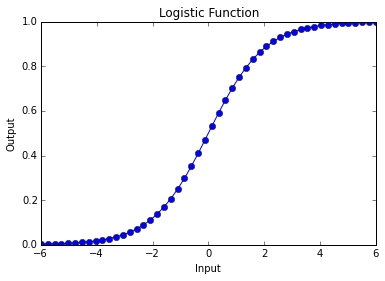

In [10]:
# define the transformation function
def logistic(z):
    # TO DO: return the output of the logistic function
    return 1.0/(1 + np.exp(-z))

# a few tests to make sure your function is working
print "Should print 0.5:"
print logistic(0)
print
print "Should print 0.81757...:"
print logistic(1.5)
print
# needs to handle arrays too
print "Should print [ 0.450166    0.5124974   0.98201379]:"
print logistic(np.array([-.2,.05,4]))
print

# graph the function 
z = np.linspace(-6,6,50)
logistic_out = logistic(z)
plt.figure()

# TO DO: write the line of code to plot the function
plt.plot(z, logistic_out, 'b-o')

plt.title("Logistic Function")
plt.xlabel('Input')
plt.ylabel('Output')
plt.show()

## 3.  Logistic Regression: A Summary

_**Data**_

We observe pairs $(\mathbf{x}_{i},y_{i})$ where
\begin{eqnarray*}
y_{i} \in \{ 0, 1\} &:& \mbox{class label} \\
\mathbf{x}_{i} = (1, x_{i,1}, \dots, x_{i,D}) &:& \mbox{set of $D$ explanatory variables (aka features) and a bias term } 
\end{eqnarray*}

_** Parameters**_

\begin{eqnarray*}
\mathbf{\beta}^{T} = (\beta_{0}, \dots, \beta_{D}) : \mbox{values encoding the relationship between the features and label}
\end{eqnarray*}

_** Transformation Function **_

\begin{equation*}
f(z_{i}=\mathbf{x}_{i} \mathbf{\beta} ) = (1+e^{-\mathbf{x}_{i} \mathbf{\beta} })^{-1}
\end{equation*}

_**Error Function**_

\begin{eqnarray*}
\mathcal{L} = \sum_{i=1}^{N} -y_{i} \log f(\mathbf{x}_{i} \mathbf{\beta} ) - (1-y_{i}) \log (1-f(\mathbf{x}_{i} \mathbf{\beta} ))
\end{eqnarray*}

In [11]:
### compute the cross-entropy error 
# labels: Numpy array containing the true class labels
# f: column vector of predictions (i.e. output of logistic function)
def cross_entropy(labels, f):
    return np.sum(-1*np.multiply(labels,np.log(f)) - np.multiply((np.ones(N)-labels),np.log(np.ones(N)-f)))

_** Learning $\beta$ **_

Like Linear Regression, learning a Logistic Regression model will entail minimizing the error function $\mathcal{L}$ above.  Can we solve for $\beta$ in closed form?  Let's look at the derivative of $\mathcal{L}$ with respect to $\beta$:

\begin{eqnarray*}
\frac{\partial \mathcal{L}_{i}}{\partial \mathbf{\beta}} &=& \frac{\partial \mathcal{L}_{i}}{\partial f(z_{i})} \frac{\partial f(z_{i})}{\partial z_{i}} \frac{\partial z_{i}}{\partial \mathbf{\beta}}\\
&=& \left[\frac{-y_{i}}{f(\mathbf{x}_{i} \mathbf{\beta})} - \frac{y_{i}-1}{1-f(\mathbf{x}_{i} \mathbf{\beta})} \right] f(\mathbf{x}_{i} \mathbf{\beta})(1-f(\mathbf{x}_{i} \mathbf{\beta}))\mathbf{x}_{i}\\
&=& [-y_{i}(1-f(\mathbf{x}_{i} \mathbf{\beta} )) - (y_{i}-1)f(\mathbf{x}_{i} \mathbf{\beta} )]\mathbf{x}_{i}\\
&=& [f(\mathbf{x}_{i} \mathbf{\beta} ) - y_{i}]\mathbf{x}_{i}
\end{eqnarray*}

In [12]:
### compute the gradient (derivative w.r.t. Beta)
# features: NxD feature matrix
# labels: Numpy array containing the true class labels
# f: column vector of predictions (i.e. output of logistic function)
def compute_Gradient(features, labels, f):
    return np.sum(np.multiply(f-labels,features),0)[np.newaxis].T

In [15]:
np.sum([1,2],0)

3

In [16]:
?np.sum

We see that the first derivative contains the term $f(X_{i}\beta)$, meaning the gradient depends on $\beta$ in some non-linear way.  We have no choice but to use the Gradient Descent algorithm:
- Randomly initialize $\beta$
- Until $\alpha || \nabla \mathcal{L} || < tol $:
    - $\mathbf{\beta}_{t+1} = \mathbf{\beta}_{t} - \alpha \nabla_{\mathbf{\beta}} \mathcal{L}$

_** Putting it all together in a simple example... **_  

Training ended after 300 iterations, taking a total of 0.86 seconds.
Final Cross-Entropy Error: 58199.60
Classification Error on Training Set: 13.75%


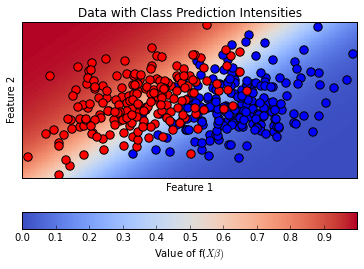

In [17]:
# set the random number generator for reproducability
np.random.seed(49)

# Randomly initialize the Beta vector
beta = np.random.multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]], 1).T
# Initialize the step-size
alpha = 0.00001
# Initialize the gradient
grad = np.infty
# Set the tolerance 
tol = 1e-6
# Initialize error
old_error = 0
error = [np.infty]

# Run Gradient Descent
start_time = time.time()
iter_idx = 1
# loop until gradient updates become small
while (alpha*np.linalg.norm(grad) > tol) and (iter_idx < 300):
    f = logistic(np.dot(features,beta))
    old_error = error[-1]
    # track the error
    error.append(cross_entropy(class_labels, f)) 
    grad = compute_Gradient(features, class_labels, f)
    # update parameters
    beta = beta - alpha*grad
    iter_idx += 1
end_time = time.time()
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Cross-Entropy Error: %.2f" %(error[-1])

# compute error on training data
predictions = logistic(np.dot(features, beta))
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

In [18]:
np.random.multivariate_normal([0,0,0], [[1,0,0],[0,1,0],[0,0,1]], 1).T.shape

(3, 1)

## 4.  Newton's Method

Choosing the step-size, $\alpha$, can be painful since there is no principled way to set it.  We have little intuition for what parameter space really looks like and therefore no sense of how to move most efficiently.  Knowing the curvature of the space will solve this problem (to some extent).  Therefore, we arrive at Newton's Method:

\begin{equation*}
\beta_{t+1} = \beta_{t} - (\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}})^{-1} \nabla_{\beta} \mathcal{L}
\end{equation*}

where $(\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}})^{-1}$ is the inverse of the matrix of second derivatives, also known as the Hessian Matrix.  For Logistic regression, the Hessian is

\begin{equation*}
\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}} = \mathbf{X}^{T}\mathbf{A}\mathbf{X}
\end{equation*}

where $\mathbf{A}= \mathrm{diag}(f(X_{i}\beta)(1-f(X_{i}\beta)))$, a matrix with $f''$ along its diagonal.

Our new parameter update is:

\begin{eqnarray*}
\beta_{t+1} &=& \beta_{t} - (\mathbf{X}^{T}\mathbf{A}\mathbf{X})^{-1}\mathbf{X}^{T}[f(\mathbf{X}\beta) - \mathbf{y}]
\end{eqnarray*}

As you can see, we no longer need to specify a step-size.  We've replaced $\alpha$ with $(\frac{\partial^{2} \mathcal{L}}{\partial \beta \partial \beta^{T}})^{-1}$ and everything else stays the same.

## <span style="color:red">STUDENT ACTIVITY (10 MINS)</span> 

Write a function that computes the Hessian matrix ($\mathbf{X}^{T}\mathbf{A}\mathbf{X}$).  

In [20]:
def compute_Hessian(features, f):
    # X = feature matrix, size NxD), 
    # f = predictions (logistic outputs), size Nx1
    # TO DO: return the Hessian matrix, size DxD 
    n = len(features)
    A = np.multiply(f,np.ones(n)[np.newaxis].T-f)
    A = np.diag(A.T[0])
    return np.dot(features.T, np.dot(A ,features))

# a few tests to make sure your function is working
X = np.array([[1,2],[3,4],[5,6]])
f = np.array([.1,.3,.5])[np.newaxis].T
print "Should print [[  8.23  10.2 ];[ 10.2   12.72]]:"
print compute_Hessian(X,f)
print
X = np.array([[1],[4],[6]])
f = np.array([.01,.13,.55])[np.newaxis].T
print "Should print [[ 10.7295]]:"
print compute_Hessian(X,f)

Should print [[  8.23  10.2 ];[ 10.2   12.72]]:
[[  8.23  10.2 ]
 [ 10.2   12.72]]

Should print [[ 10.7295]]:
[[ 10.7295]]


_** Let's try Newton's Method on our simple example... **_ 

Training ended after 9 iterations, taking a total of 0.03 seconds.
Final Cross-Entropy Error: 39383.14
Classification Error on Training Set: 9.50%


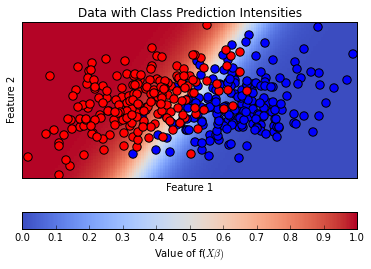

In [21]:
# set the random number generator for reproducability
np.random.seed(1801843607)

# Save the errors from run above
no_Newton_errors = error

# Randomly initialize the Beta vector
beta = np.random.multivariate_normal([0,0,0], [[.1,0,0],[0,.1,0],[0,0,.1]], 1).T
# Initialize error
old_error = 0
error = [np.infty]

# Run Newton's Method
start_time = time.time()
iter_idx = 1
# Loop until error doesn't change (as opposed to gradient)
while (abs(error[-1] - old_error) > tol) and (iter_idx < 300):
    f = logistic(np.dot(features,beta))
    old_error = error[-1]
    # track the error
    error.append(cross_entropy(class_labels, f)) 
    grad = compute_Gradient(features, class_labels, f)
    hessian = compute_Hessian(features,f)
    # update parameters via Newton's method
    beta = beta - np.dot(np.linalg.inv(hessian),grad)
    iter_idx += 1
end_time = time.time()
print "Training ended after %i iterations, taking a total of %.2f seconds." %(iter_idx, end_time-start_time)
print "Final Cross-Entropy Error: %.2f" %(error[-1])

# compute the classification error on training data
predictions = logistic(np.dot(features, beta))
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, beta, logistic_flag=True)

Let's look at the training progress to see how much more efficient Newton's method is.

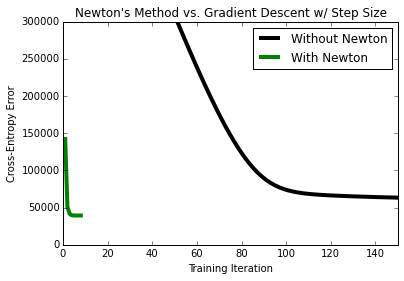

In [22]:
# plot difference between with vs without Newton
plt.figure()
# grad descent w/ step size
plt.plot(range(len(no_Newton_errors)), no_Newton_errors, 'k-', linewidth=4, label='Without Newton')
# newton's method
plt.plot(range(len(error)), error, 'g-', linewidth=4, label='With Newton')
plt.ylim([0,300000])
plt.xlim([0,150])
plt.legend()
plt.title("Newton's Method vs. Gradient Descent w/ Step Size")
plt.xlabel("Training Iteration")
plt.ylabel("Cross-Entropy Error")
plt.show()

## 5.  Logistic Regression with SciKit-Learn 

[Here is the documentation for SciKit-Learn's implementation of Logistic Regression](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)

It's quite easy to use.  Let's jump right in and repeat the above experiments.

Training ended after 0.0015 seconds.
Classification Error on Training Set: 9.75%


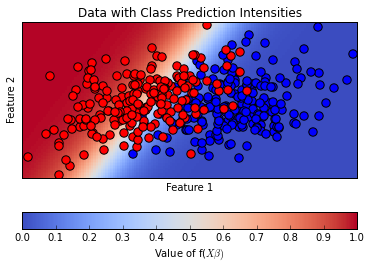

In [24]:
from sklearn.linear_model import LogisticRegression

# set the random number generator for reproducability
np.random.seed(75)

#Initialize the model
skl_LogReg = LogisticRegression()

#Train it
start_time = time.time()
skl_LogReg.fit(features, np.ravel(class_labels))
end_time = time.time()
print "Training ended after %.4f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = skl_LogReg.predict(features)
print "Classification Error on Training Set: %.2f%%" %(calc_classification_error(predictions, class_labels) * 100)

# generate the plot
plot_classification_data(class1_features, class2_features, skl_LogReg.coef_.T, logistic_flag=True)

# Experiments

## 6.  Dataset #1: NBA Shot Outcomes

The first real dataset we'll tackle is one describing the location and outcome of shots taken in professional basketball games.  Let's use Pandas to load and examine the data.    

In [25]:
nba_shot_data = pd.read_csv('./data/nba_experiment/NBA_xy_features.csv')
nba_shot_data.head()

,x_Coordinate,y_Coordinate,shot_outcome
0,26.0,32.0,0.0
1,25.0,24.0,0.0
2,25.0,6.0,1.0
3,40.0,7.0,1.0
4,12.0,13.0,1.0


In [26]:
nba_shot_data.describe()

,x_Coordinate,y_Coordinate,shot_outcome
count,562538.000000,562538.000000,562538.000000
mean,25.178772,13.496301,0.458145
std,11.212500,8.651198,0.498246
min,-3.000000,1.000000,0.000000
25%,19.000000,6.000000,0.000000
50%,25.000000,10.000000,0.000000
75%,31.000000,21.000000,1.000000
max,51.000000,94.000000,1.000000


Simple enough.  Now let's train a Logistic Regression model on it, leaving out a test set.

Training ended after 0.46 seconds.
Classification Error on the Test Set: 41.87%
Baseline Error: 45.79%


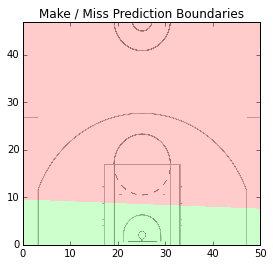

In [27]:
# split data into train and test
train_set_size = int(.80*len(nba_shot_data))
train_features = nba_shot_data.ix[:train_set_size,['x_Coordinate','y_Coordinate']]
test_features = nba_shot_data.ix[train_set_size:,['x_Coordinate','y_Coordinate']]
train_class_labels = nba_shot_data.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_shot_data.ix[train_set_size:,['shot_outcome']]

#Train it
start_time = time.time()
skl_LogReg.fit(train_features, np.ravel(train_class_labels))
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = skl_LogReg.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# visualize the boundary on the basketball court
visualize_court(skl_LogReg)

Not bad.  We're beating the random baseline of 45% error.  However, visualizing the decision boundary exposes a systemic problem with using a linear model on this dataset: it is not powerful enough to adapt to the geometry of the court.  This is a domain-specific contraint that should be considered when selecting the model and features.  For instance, a Gaussian-based classifier works a bit better, achieving 39.02% error.  Its decision boundary is visualized below.

<img src="https://raw.githubusercontent.com/enalisnick/NBA_shot_analysis/master/results/spatial_features_results/Gaussian_Mixture_Model.png" alt="" style="width: 250px;"/>

Can we do better by adding more features?  For instance, if we knew the position (Guard vs. Forward vs. Center) of the player taking the shot, would that help?  Let's try.  First, load a new dataset.

In [28]:
# first we need to extract the file from the zip
import zipfile
zip = zipfile.ZipFile('./data/nba_experiment/NBA_all_features.csv.zip')
zip.extractall('./data/nba_experiment/')

nba_all_features = pd.read_csv('./data/nba_experiment/NBA_all_features.csv')
nba_all_features.head()

,x_Coordinate,y_Coordinate,layup,dunk,3pt,hook,jumper,fade_away,Guard,Forward,Center,shot_outcome
0,45.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,37.0,27.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,24.0,33.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,25.0,6.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
4,42.0,18.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0


One thing to notice is that this data is noisy.  Look at row 2 above; it says a player made a dunk from 33 feet above the baseline--that's beyond the three point line. 

## <span style="color:red">STUDENT ACTIVITY (20 MINS)</span> 

Your task is to train Scikit-Learn's Logistic Regression model on the new NBA data.  The data is split into train and test features already.  Your task is to train SciKit-Learn's Logistic Regression model on the *train_features* and *train_class_labels* and then compute the test classification error--which should be around 38%-39%.  **BONUS:** If you sucessfully train the SciKit-Learn model, implement gradient descent or Newton's method.

In [31]:
# split data into train and test
train_features = nba_all_features.ix[:train_set_size,:'Center']
test_features = nba_all_features.ix[train_set_size:,:'Center']
train_class_labels = nba_all_features.ix[:train_set_size,['shot_outcome']]
test_class_labels = nba_all_features.ix[train_set_size:,['shot_outcome']]

########## TO DO: TRAIN SCIKIT-LEARN'S LOG. REG. MODEL ##########

skl_LogReg.fit(train_features, np.ravel(train_class_labels))
predictions = skl_LogReg.predict(test_features)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, np.array(test_class_labels)) * 100)


#################################################################

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(np.sum(test_class_labels)/len(test_class_labels)*100)

# we can't visualize since D>2

Classification Error on the Test Set: 38.96%
Baseline Error: 45.91%


Great!  We've improved by a few percentage points.  Let's look at which features the model weighted.

In [32]:
for idx, feature in enumerate(nba_all_features):
    if idx<11:
        print "%s: %.2f" %(feature, skl_LogReg.coef_[0][idx])

x_Coordinate: -0.00
y_Coordinate: -0.01
layup: -0.00
dunk: -0.04
3pt: -0.05
hook: 0.26
jumper: 0.86
fade_away: 0.75
Guard: 0.89
Forward: 0.27
Center: 3.07


Interestingly, the classifier exploited the location features very little.  The position of the player was much more important, especially if he was a center.

 ## 7.  Dataset #2: 20 News Groups

For the second experiment, we'll work with the very popular '20 News Groups' dataset consisting of, well, 20 different categories of articles.  SciKit-Learn already has it ready for import.

In [34]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer

# use SciKit Learn's loading methods
categories = ['soc.religion.christian', 'alt.atheism']
train_20ng = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
test_20ng = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

# transform the text into word counts
vectorizer = CountVectorizer(stop_words='english', max_features=1000)
train_vectors = vectorizer.fit_transform(train_20ng.data)
test_vectors = vectorizer.transform(test_20ng.data) #use the transform fit to the training data

train_targets = train_20ng.target
test_targets = test_20ng.target

print "The training data size is "+str(train_vectors.shape)
print "The test data size is "+str(test_vectors.shape)
# print the first 500 words of an article
print "Example text:"
print train_20ng.data[0][:500]
print
print "Example count vector:"
#print train_vectors[0].todense()

The training data size is (1079, 1000)
The test data size is (717, 1000)
Example text:
Library of Congress to Host Dead Sea Scroll Symposium April 21-22
 To: National and Assignment desks, Daybook Editor
 Contact: John Sullivan, 202-707-9216, or Lucy Suddreth, 202-707-9191
          both of the Library of Congress

   WASHINGTON, April 19  -- A symposium on the Dead Sea 
Scrolls will be held at the Library of Congress on Wednesday,
April 21, and Thursday, April 22.  The two-day program, cosponsored
by the library and Baltimore Hebrew University, with additional
support from the Pr

Example count vector:


As you can see, the vector is super sparse and very high dimensional--much different than the data we've been working with previously.  Let's see how SciKit-Learn's Logistic Regression model handles it.  

In [35]:
#Train it
start_time = time.time()
skl_LogReg.fit(train_vectors, train_targets)
end_time = time.time()
print "Training ended after %.2f seconds." %(end_time-start_time)

# compute the classification error on training data
predictions = skl_LogReg.predict(test_vectors)
print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, test_targets) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(100 - sum(test_targets)*100./len(test_targets))

Training ended after 0.02 seconds.
Classification Error on the Test Set: 23.99%
Baseline Error: 44.49%


24% error is respectable, but there's still room for improvement.  In general, working with natural language is one of the hardest application domains in Machine Learning due to the fact that we often have to reduce the abstract, sometimes ambiguous semantic meaning to a superficial token.  

## <span style="color:red">STUDENT ACTIVITY</span>

In the time remaining in the session, we'd like you to try an open-ended activity to get experience implementing the full prediction pipeline.  We've provided some suggestions below, but feel free to improvise.  

### Suggestion #1: Feature Engineering for 20 News Groups
Can you beat the baseline error rate on the 20 News Groups dataset?  One way to do this is to have better features--word counts are rather blunt.  Go read about [TFIDF](http://www.tfidf.com/) and then use SciKit-Learn's [TFIDF Vectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html) to compute a new feature matrix for the 20 News Groups dataset.  You should be able to get an error rate of about 40% if not better.  The code is started for you below.

In [36]:
from sklearn.feature_extraction.text import TfidfVectorizer


#### YOUR CODE GOES HERE


print "Classification Error on the Test Set: %.2f%%" %(calc_classification_error(predictions, test_targets) * 100)

# compute the baseline error since the classes are imbalanced
print "Baseline Error: %.2f%%" %(100 - sum(test_targets)*100./len(test_targets))

Classification Error on the Test Set: 23.99%
Baseline Error: 44.49%


### Suggestion #2: Step-Size vs. Newton's Method for the NBA dataset
We saw the benefits of using Newton's method earlier (in section 4), but the dataset was small and artificial.  Try implementing Gradient Descent with a step-size and Newton's method for one of the NBA datasets.  Then compare their convergence rates by recreating the plot above showing Error vs. Training Iteration.   

### Suggestion #3: Train Logistic Regression on a new dataset
UCI's Center for Machine Learning hosts a large repository of datasets.  You can find it [here](http://archive.ics.uci.edu/ml/).  The datasets appropriate for classification are [here](http://archive.ics.uci.edu/ml/datasets.html?format=&task=cla&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table).  Find one you think looks interesting, download it, and run SciKit-Learn's Logistic Regression model on it.  

### Suggestion #4: Explore SciKit-Learn
We've barely scratched the surface of SciKit-Learn today.  There are many more models to try; explore them [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning).  Select one, import it, and run it on the datasets above, comparing performance.  We suggest trying a [Random Forrest](http://scikit-learn.org/stable/modules/ensemble.html#random-forests) or a [Support Vector Machine](http://scikit-learn.org/stable/modules/svm.html).